# Лаба ИАД 2

## Обработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
train_data = pd.read_csv('/content/drive/MyDrive/DataSets/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DataSets/fashion-mnist_test.csv')

In [56]:
labels = {0 : "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

In [57]:
def get_classes_distribution(data):
    label_counts = data["label"].value_counts()
    total_samples = len(data)

    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Ankle Boot          :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Coat                :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Trouser             :   6000 or 10.0%
T-shirt             :   6000 or 10.0%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



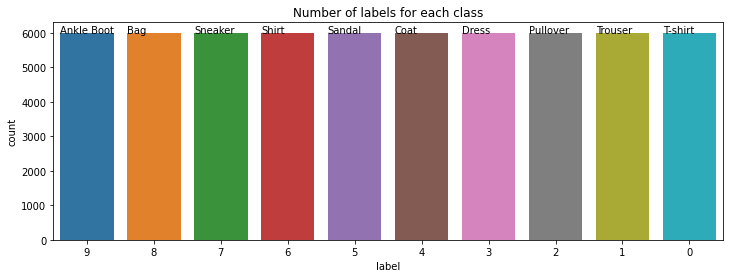

In [58]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(train_data)

In [59]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


In [60]:
def sample_images_data(data):
    sample_images = []
    sample_labels = []

    for k in labels.keys():
        samples = data[data["label"] == k].head(4)
        for j, s in enumerate(samples.values):
            img = np.array(samples.iloc[j, 1:]).reshape(28,28)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


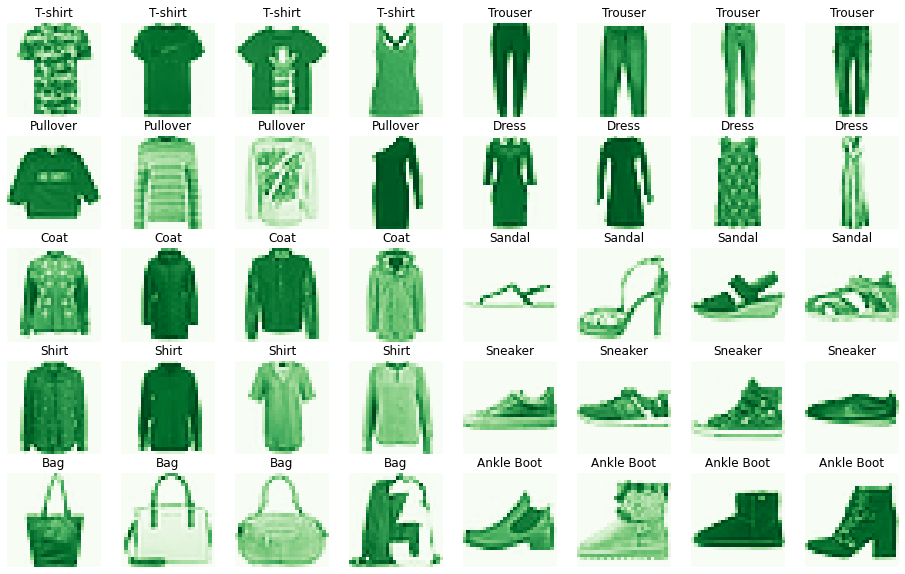

In [61]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    f, ax = plt.subplots(5,8, figsize=(16,10))
    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

Total number of sample images to plot:  40


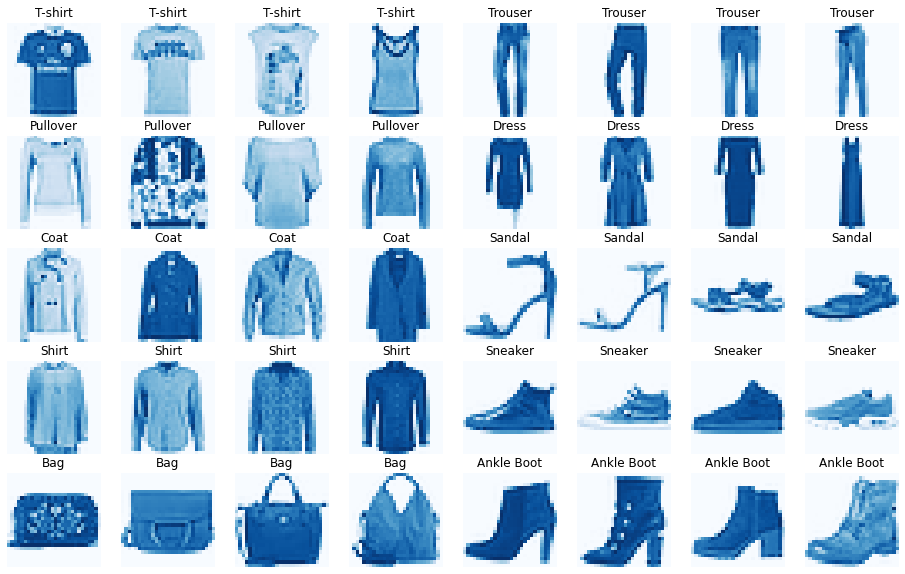

In [62]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

## Модели

### Модель 1

#### Предобработка данных

In [76]:
def data_preprocessing(raw):
    out_y = keras.utils.np_utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [77]:
x_train, y_train = data_preprocessing(train_data)
x_test, y_test = data_preprocessing(test_data)

In [78]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=2018)

In [79]:
print("Fashion MNIST train -  rows:",x_train.shape[0]," columns:", x_train.shape[1:4])
print("Fashion MNIST valid -  rows:",x_valid.shape[0]," columns:", x_valid.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


In [80]:
print("Fashion MNIST train -  rows:",y_train.shape[0]," columns:", y_train.shape[1:4])
print("Fashion MNIST valid -  rows:",y_valid.shape[0]," columns:", y_valid.shape[1:4])
print("Fashion MNIST test -  rows:",y_test.shape[0]," columns:", y_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (10,)
Fashion MNIST valid -  rows: 12000  columns: (10,)
Fashion MNIST test -  rows: 10000  columns: (10,)


#### Перцептрон

In [81]:
from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [82]:
model_1 = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])
model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [83]:
model_1.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0959 - accuracy: 0.8139 - val_loss: 0.0792 - val_accuracy: 0.8418
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0716 - accuracy: 0.8580 - val_loss: 0.0693 - val_accuracy: 0.8587
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0656 - accuracy: 0.8698 - val_loss: 0.0638 - val_accuracy: 0.8712
Epoch 4/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0620 - accuracy: 0.8769 - val_loss: 0.0623 - val_accuracy: 0.8752
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0592 - accuracy: 0.8814 - val_loss: 0.0598 - val_accuracy: 0.8809
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0564 - accuracy: 0.8877 - val_loss: 0.0598 - val_accuracy: 0.8818
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0547 - accuracy: 0.8914 - val_loss: 0.0583 - val_accuracy:

In [84]:
model_1.evaluate(x_valid, y_valid)

375/375 [==============================] - 1s 3ms/step - loss: 0.0563 - accuracy: 0.8906


[0.0563318133354187, 0.890583336353302]

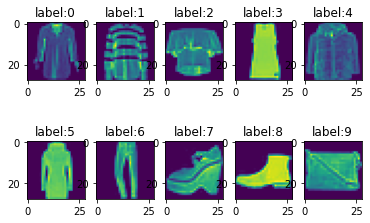

In [86]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title("label:" + str(i))
    plt.imshow(x_valid[i].reshape(28, 28), cmap=None)

In [75]:
model_1.predict(x_valid[0:10])

array([[2.1698999e-05, 3.3872976e-09, 5.3964191e-05, 2.7520067e-04,
        1.4399574e-03, 8.0014253e-08, 9.9820828e-01, 7.2198698e-11,
        7.1898370e-07, 4.4103700e-08],
       [4.2353431e-03, 1.0611501e-08, 4.4552814e-02, 1.5159337e-03,
        8.6908126e-03, 3.9373457e-08, 9.4006795e-01, 3.5534228e-10,
        9.3709520e-04, 5.5158638e-09],
       [1.8105072e-01, 7.7711348e-08, 7.5748856e-03, 2.5481542e-05,
        5.1813666e-05, 2.3454176e-09, 8.1100982e-01, 9.8112473e-08,
        2.8699808e-04, 8.1683083e-10],
       [9.3352985e-01, 2.3316578e-03, 7.5049471e-04, 2.3618912e-02,
        1.2718410e-04, 9.2289271e-10, 3.9533179e-02, 8.9348991e-15,
        1.0866968e-04, 2.6025784e-09],
       [6.0597733e-02, 3.5904568e-02, 3.2808021e-01, 1.2352441e-02,
        1.0246182e-01, 1.4488974e-05, 1.2340247e-01, 1.1942208e-05,
        3.3714005e-01, 3.4280340e-05],
       [7.6749553e-03, 1.8226000e-02, 3.6873487e-01, 4.1439526e-02,
        5.4565519e-01, 4.8272701e-09, 1.3580468e-02, 1.63

In [87]:
classes = model_1.predict(x_test, batch_size=128)
y_pred = model_1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0564 - accuracy: 0.8910


In [88]:
test_classes = [np.argmax(y_test[i]) for i in range(len(y_test))]
pred_classes  = [np.argmax(classes[i]) for i in range(len(classes))]
print(classification_report(test_classes, pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1000
           1       0.98      0.99      0.98      1000
           2       0.87      0.75      0.81      1000
           3       0.91      0.91      0.91      1000
           4       0.76      0.90      0.82      1000
           5       0.98      0.95      0.96      1000
           6       0.74      0.68      0.71      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.98      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Результат получился хороший для простенькой модели

### Модель 2

#### Предобработка данных

In [17]:
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

In [18]:
x_train = np.array(train_data.iloc[:,1:])
x_test = np.array(test_data.iloc[:,1:])
y_train = np.array (train_data.iloc[:,0])
y_test = np.array(test_data.iloc[:,0])

In [20]:
classes = np.unique(y_train)
num_classes = len(classes)
num_classes

10

In [21]:
x_train=np.dstack([x_train]*3)
x_test=np.dstack([x_test]*3)
x_train.shape,x_test.shape

((60000, 784, 3), (10000, 784, 3))

In [22]:
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)
x_train.shape,x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [23]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [24]:
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [26]:
# Преобразование лейблы к формату one hot encoded
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [27]:
x_train.shape

(60000, 48, 48, 3)

In [28]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train, y_train_one_hot,
                                                   test_size=0.2, random_state=13)

In [29]:
# Проверка размерности данных, соответствует ли она требованиям VGG16.
x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [30]:
# Предварительная обработка ввода
x_train = preprocess_input(x_train)
x_valid = preprocess_input(x_valid)
x_test  = preprocess_input (x_test)

#### VGG-16

In [32]:
from keras import models
from keras.models import Model
from keras import layers
from tensorflow.keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [46]:
NB_EPOCHS = 30

model = models.Sequential()
model.add(VGG16(weights='imagenet',include_top=False,input_shape=(48, 48, 3)))
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='sigmoid'))

In [47]:
model.layers[0].trainable = False

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Добавляем сокращение обучения и раннюю остановку для обратного вызова 
reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                                              patience=2, verbose=1, mode='auto',
                                              min_delta=0.0001, cooldown=2, min_lr=0)

eary_stopping = callbacks.EarlyStopping(monitor='val_loss',min_delta=0,
                                        patience=7, verbose=1, mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [49]:
history = model.fit(x_train, y_train, epochs=NB_EPOCHS,
                    validation_data=(x_valid, y_valid), callbacks=callbacks)

Epoch 1/30
1500/1500 [==============================] - 52s 34ms/step - loss: 0.2248 - accuracy: 0.4718 - val_loss: 0.1776 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 52s 34ms/step - loss: 0.1675 - accuracy: 0.6266 - val_loss: 0.1578 - val_accuracy: 0.6559 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 51s 34ms/step - loss: 0.1541 - accuracy: 0.6578 - val_loss: 0.1466 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 51s 34ms/step - loss: 0.1457 - accuracy: 0.6762 - val_loss: 0.1390 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 52s 35ms/step - loss: 0.1397 - accuracy: 0.6927 - val_loss: 0.1588 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 6/30
1500/1500 [==============================] - 52s 34ms/step - loss: 0.1369 - accuracy: 0.6997 - val_loss: 0.1340 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 7/30
1500/1500 [========================

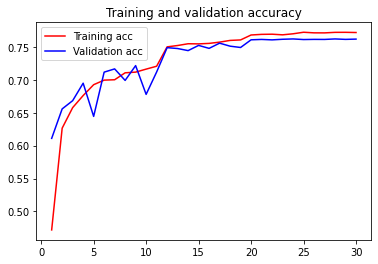

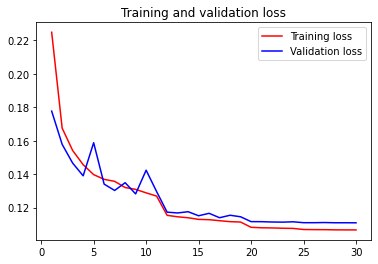

In [52]:
# График потерь и точности 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Результат получился плохим на мой взгляд. Попытки поиграть с настройками модели или добавить пару слоев не дали особых результатов. Всё было с разницей 1-2 процента с разными настройками. Возможно из-за увеличения размерности картинки и добавления 2 слоев для модели vgg16 дали плохие результаты.